In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
import copy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [9]:
# import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
# import torchvision
from torch.utils.data import Dataset

In [28]:
### process every xml files to be 'filename':[[xmin_room1,xmax_room1,ymin_room1,ymax_room1,label_room1],
### [xmin_room2,xmax_room2,ymin_room2,ymax_room2,label_room2],...]

directName = "./data_1"
# directName = "./"
script_dict = {}   ### record of each figure and each room of it
room_dict = {}     ### labels for different room: living room, bedroom, ...
room_count = {}
xy_dist = []
for file in os.listdir(directName):
    if file.endswith(".xml"):
        fileNamePre = file[:-4]
        tree = ET.parse(os.path.join(directName, file))
        root = tree.getroot()
        script_dict[fileNamePre] = []
        for item in root.findall('object'):
            rooms = [None]*5
            for child in item:
                if(child.tag == 'name'):
                    room_type = child.text
                    room_type_digit = -1
                    if(room_type in room_dict):
                        room_type_digit = room_dict[room_type]
                        room_count[room_type_digit] = room_count[room_type_digit] + 1
                    else:
                        room_type_digit = len(room_dict)
                        room_dict[room_type] = room_type_digit 
                        room_count[room_type_digit] = 1
                    rooms[4] = room_type_digit
                elif(child.tag == 'bndbox'):
                    for grandchild in child:
                        if grandchild.tag=='xmin':
                            rooms[0] = int(grandchild.text)
                        elif grandchild.tag=='xmax':
                            rooms[1] = int(grandchild.text)
                        elif grandchild.tag=='ymin':
                            rooms[2] = int(grandchild.text)
                        elif grandchild.tag=='ymax':
                            rooms[3] = int(grandchild.text)
            xy_dist.append(rooms[1]-rooms[0])
            xy_dist.append(rooms[3]-rooms[2])
            script_dict[fileNamePre].append(rooms)

In [3]:
script_dict

{'0134b1-1': [[975, 1200, 823, 955, 0],
  [721, 946, 824, 1092, 1],
  [719, 1102, 1118, 1579, 2],
  [1562, 1875, 968, 1302, 2],
  [1134, 1532, 1107, 1575, 3],
  [1236, 1538, 819, 1105, 4],
  [1559, 1879, 737, 940, 5]],
 '0134b2-1': [[2062, 2428, 794, 960, 1],
  [2055, 2431, 518, 757, 6],
  [1238, 1606, 526, 877, 2],
  [2057, 2431, 999, 1399, 2],
  [1238, 2036, 904, 1391, 3],
  [1630, 2042, 519, 885, 4]],
 '0134b2-2': [[2084, 2453, 746, 919, 1],
  [2065, 2452, 477, 714, 6],
  [1261, 1628, 858, 1351, 2],
  [2087, 2451, 942, 1350, 2],
  [1260, 1628, 473, 827, 2],
  [1658, 2062, 475, 1350, 3],
  [1643, 2069, 1378, 1591, 7]],
 '0134b3-1': [[1586, 1727, 667, 961, 1],
  [1407, 1565, 660, 972, 6],
  [1153, 1386, 661, 956, 2],
  [1405, 1663, 1112, 1477, 2],
  [1882, 2201, 1106, 1418, 3],
  [1746, 2017, 662, 954, 4],
  [2045, 2204, 662, 960, 5],
  [1154, 1382, 977, 1411, 8]],
 '0134b3-2': [[1658, 1798, 742, 1044, 1],
  [2111, 2275, 747, 938, 1],
  [1475, 1633, 745, 1043, 6],
  [1480, 1732, 1200,

In [4]:
room_dict

{'storage': 0,
 'bathroom': 1,
 'bedroom': 2,
 'living room': 3,
 'dining room': 4,
 'kitchen': 5,
 'stairs': 6,
 'balcony': 7,
 'garage': 8}

In [61]:
room_count

{0: 34, 1: 259, 2: 339, 3: 198, 4: 56, 5: 78, 6: 203, 7: 77, 8: 28, 9: 5}

In [71]:
total_rooms = 0
for key in room_count:
    total_rooms += room_count[key]

In [81]:
weights = [None]*10
for i in range(10):
    weights[i] = total_rooms/room_count[i]

In [82]:
weights = torch.from_numpy(np.array(weights).astype(np.float32))

(array([12., 14., 20., 19.,  5.,  0.,  0.,  0.,  1.,  1.]),
 array([132. , 206.3, 280.6, 354.9, 429.2, 503.5, 577.8, 652.1, 726.4,
        800.7, 875. ]),
 <BarContainer object of 10 artists>)

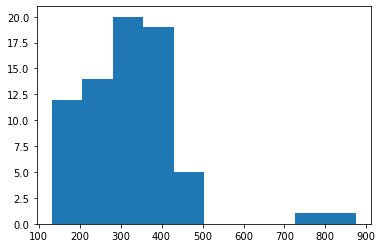

In [6]:
plt.hist(xy_dist)

In [10]:
# def split_rooms_coords(directName, script_dict, resize_scale):
#     X_cor = []
#     Y_cor = []
#     for file in os.listdir(directName): 
#         if file.endswith(".xml"):
#             fileNamePre = file[:-4]
#             img = cv2.imread(fileNamePre+'.png', cv2.IMREAD_GRAYSCALE)
#             coords = script_dict[fileNamePre]
#             for cor in coords:
#                 img_part = img[cor[2]:cor[3],cor[0]:cor[1]]
#                 img_part = cv2.resize(img_part, (resize_scale,resize_scale))
#                 X_cor.append(img_part)
#                 Y_cor.append(cor[4])
#                 X_cor.append(np.rot90(img_part,2))
#                 Y_cor.append(cor[4])
#     X_cor = np.array(X_cor)
#     Y_cor = np.array(Y_cor)
#     return np.expand_dims(X_cor, axis=1), Y_cor    

In [11]:
# X,Y = split_rooms_coords(directName,script_dict,300)

In [119]:
def split_rooms_coords_rot(directName, script_dict, resize_scale, test_ratio):
    X_cor = []
    Y_cor = []
    for file in os.listdir(directName): 
        if file.endswith(".xml"):
            fileNamePre = file[:-4]
            filePath = os.path.join(directName, fileNamePre+'.png')
#             print(fileNamePre)
            img = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
            coords = script_dict[fileNamePre]
            for cor in coords:
                if(cor[4]!=1 and cor[4]!=2 and cor[4]!=3 and cor[4]!=6):
                    continue
                img_part = img[cor[2]:cor[3],cor[0]:cor[1]]
                img_part = cv2.resize(img_part, (resize_scale,resize_scale))
                X_cor.append(img_part)
                Y_cor.append(cor[4])
                X_cor.append(np.rot90(img_part,1))  ## rotate 90 degree
                Y_cor.append(cor[4])
                X_cor.append(np.rot90(img_part,2))  ## rotate 180 degree
                Y_cor.append(cor[4])
#                 if(cor[4]!=1 and cor[4]!=2 and cor[4]!=3 and cor[4]!=6):
#                     X_cor.append(np.rot90(img_part,3))  ## rotate 270 degree
#                     Y_cor.append(cor[4])
#                     X_cor.append(np.flipud(img_part))  ## updown
#                     Y_cor.append(cor[4])
#                     X_cor.append(np.fliplr(img_part))  ## leftright
#                     Y_cor.append(cor[4])
    X_cor = np.array(X_cor)
    Y_cor = np.array(Y_cor)
    X, y = shuffle(X_cor, Y_cor, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
    return X_train, X_test, y_train, y_test   

In [120]:
X_train, X_test, y_train, y_test = split_rooms_coords_rot(directName, script_dict, 300, 0.1)

In [121]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.nbytes*1e-9, X_test.nbytes*1e-9, y_train.nbytes*1e-9, y_test.nbytes*1e-9)

(2697, 300, 300) (300, 300, 300) (2697,) (300,)
0.24273 0.027000000000000003 1.0788e-05 1.2000000000000002e-06


In [122]:
batch_size = 200
momentum = 0.9
lr = 0.01
epochs = 10
log_interval = 4
nclasses = len(room_dict)

In [123]:
class MyDataset(Dataset):

    def __init__(self, X, y):

        self.X = torch.from_numpy(np.expand_dims(X, axis=1).astype(np.float32))
#         self.y = torch.from_numpy(y.astype(np.float32).reshape([-1,1]))
        self.y = torch.from_numpy(y.reshape([-1,1]).squeeze(1)).long()
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
# val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# val_loader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [124]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=5)
        self.conv2 = nn.Conv2d(3, 3, kernel_size=10)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(300, 100)
        self.fc2 = nn.Linear(100, nclasses)
        self.batchNorm1 = nn.BatchNorm2d(3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.batchNorm1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.batchNorm1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.batchNorm1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.batchNorm1(x)
        x = x.view(-1, 300)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [125]:
model = Net()
# criterion = nn.CrossEntropyLoss(weight = weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [130]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
#         loss = F.nll_loss(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
#     model.eval()
#     true_num = 0
#     total_num = 0
#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(test_loader):
#             output = model(data)
#             output_labels = np.argmax(output, axis=1)
#             true_num += (output_labels==target).sum()
#             total_num += output_labels.shape[0]
#     print('test accuracy:',true_num/total_num)
#     model.train()

In [128]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(epochs):
    train(epoch)
    test()